<a href="https://colab.research.google.com/github/JonRivera/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [227]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [228]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [229]:
df.shape

(423, 66)

In [230]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [231]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [232]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [233]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [234]:
print(df.shape)

df.head()

(421, 59)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 0 to 422
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Date            421 non-null    object 
 2   Yelp            87 non-null     float64
 3   Google          87 non-null     float64
 4   Chips           26 non-null     object 
 5   Cost            414 non-null    float64
 6   Hunger          418 non-null    float64
 7   Mass (g)        22 non-null     float64
 8   Density (g/mL)  22 non-null     float64
 9   Length          283 non-null    float64
 10  Circum          281 non-null    float64
 11  Volume          281 non-null    float64
 12  Tortilla        421 non-null    float64
 13  Temp            401 non-null    float64
 14  Meat            407 non-null    float64
 15  Fillings        418 non-null    float64
 16  Meat:filling    412 non-null    float64
 17  Uniformity      419 non-null    flo

# **Data Wrangling** to get Traing and Testing Set

In [266]:
import pandas as pd
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
train = df[df['Date'].dt.year <= 2016]
validate = df[df['Date'].dt.year.isin([2017])]
test = df[df['Date'].dt.year.isin([2018])]
train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [267]:
train = df[df['Date'].dt.year.isin([2016])]

In [268]:
train.shape, test.shape

((296, 59), (27, 59))

# **Train Validation Split**

In [269]:
#train test split
from sklearn.model_selection import train_test_split
train, val = train_test_split(train,test_size =.2, random_state = 42)
train.shape, test.shape

((236, 59), (27, 59))

In [270]:
#why did did it split between 222 and 27 observation
#by default train_size is set to .75 --- representing the proportion of the data set

target = 'Great'
y_train = train[target]
y_train.value_counts(normalize = True)

#train, val = train_test_split(train, random_state = 42)
#test_size=0.2, random_state=42

False    0.584746
True     0.415254
Name: Great, dtype: float64

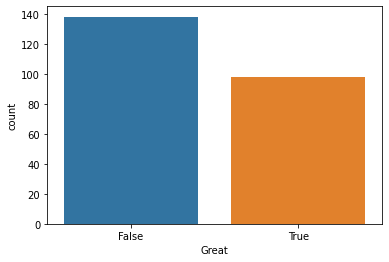

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y_train)

# **ESTABLISH BASELINE**

In [272]:
#majority_class consists of False values
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)


In [273]:
from sklearn.metrics import accuracy_score
#In multilabel classification, this function computes subset accuracy:
#the set of labels predicted for a sample must exactly match the corresponding set of labels in y_tr
#the accuracy is the frequency of the majority class
print(f'{accuracy_score(y_train, y_pred)}, accuracy for training set')

0.5847457627118644, accuracy for training set


In [274]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val,y_pred)
print(f'{accuracy_score(y_val,y_pred)}, accuracy for validation set')


0.6166666666666667, accuracy for validation set


# **Build Model** 

In [245]:
#logistic regression does a transformation that forces outcome of linear model to be
#flat or squished so the output is between 0,1, special case of linear regression


In [246]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,222,222,17,22,3,125,108,105,105,87,58,31,13,17,5,27,21,6,6,4,1,7,27,3,10,11,4,5,1,3,3,1,3,1,1,2,10,2,0,222
unique,5,101,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,0,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,X,x,x,x,x,X,X,x,x,x,x,x,x,x,x,x,x,x,X,NaN,False
freq,89,22,14,22,2,96,86,74,86,74,43,21,12,15,3,19,14,4,4,2,1,5,24,2,5,6,3,4,1,3,3,1,3,1,1,2,10,1,NaN,128
first,NaN,2016-01-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [275]:

#arrange y_val an
#import the estimator class
from sklearn.linear_model import LinearRegression

# instantiate this class
linear_reg = LinearRegression()

features = ['Burrito','Chips','Cheese','Chicken','Beef']
target = 'Great'

# arrange X feature matrices and y target vectors
y_train = train[target]
y_train.value_counts(normalize = True)





False    0.584746
True     0.415254
Name: Great, dtype: float64

# **Seperating Between Training and Validation Data Sets**

In [276]:

#Traing Test Split
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape,y_val.shape



((236, 5), (236,), (60, 5), (60,))

In [277]:
X_train

,Burrito,Chips,Cheese,Chicken,Beef
63,Carnitas,NaN,NaN,NaN,NaN
17,Other,NaN,NaN,NaN,NaN
220,Other,NaN,x,x,NaN
224,Other,NaN,NaN,NaN,NaN
188,Asada,NaN,NaN,NaN,x
...,...,...,...,...,...
193,Other,x,NaN,NaN,NaN
71,Other,NaN,NaN,NaN,NaN
107,Other,NaN,NaN,NaN,NaN
275,California,NaN,NaN,NaN,NaN


In [278]:
#import classes
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [251]:
X_train.head()

,Burrito,Chips,Cheese,Chicken,Beef
80,California,x,X,NaN,X
121,Other,NaN,NaN,NaN,NaN
72,California,NaN,NaN,NaN,NaN
15,California,NaN,x,NaN,x
10,Surf & Turf,NaN,NaN,NaN,x


In [279]:
#one hot encoding for both X_train and X_val
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded =  encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_train_encoded.head()

,Burrito_Carnitas,Burrito_Other,Burrito_Asada,Burrito_California,Burrito_Surf & Turf,Chips_nan,Chips_x,Chips_X,Cheese_nan,Cheese_x,Cheese_X,Chicken_nan,Chicken_x,Chicken_X,Beef_nan,Beef_x,Beef_X
63,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
17,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
220,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
224,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
188,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [280]:
#impute both X_train and X_Val to remove null values w/ the mean
imputer = SimpleImputer(strategy = 'mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

print(X_train_imputed.shape)
X_train_imputed

(236, 17)


array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

In [281]:
#Scale data set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
print(X_train_scaled.shape, X_val_scaled.shape)
X_train_scaled

(236, 17) (60, 17)


array([[ 3.98210282, -0.7365349 , -0.35942538, ...,  1.11696869,
        -0.86495558, -0.38161639],
       [-0.2511236 ,  1.35770891, -0.35942538, ...,  1.11696869,
        -0.86495558, -0.38161639],
       [-0.2511236 ,  1.35770891, -0.35942538, ...,  1.11696869,
        -0.86495558, -0.38161639],
       ...,
       [-0.2511236 ,  1.35770891, -0.35942538, ...,  1.11696869,
        -0.86495558, -0.38161639],
       [-0.2511236 , -0.7365349 , -0.35942538, ...,  1.11696869,
        -0.86495558, -0.38161639],
       [-0.2511236 ,  1.35770891, -0.35942538, ..., -0.89528025,
        -0.86495558,  2.62043253]])

In [282]:
#fit model with X_train_scaled and y_train
model = LogisticRegression()
model.fit(X_train_scaled,y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [283]:
y_pred = model.predict(X_train_scaled)
print(f'{accuracy_score(y_train,y_pred)}, accuracy for training set')

0.6483050847457628, accuracy for training set


In [284]:
#find the y_pred vector and test accuracy  for validation set
y_pred = model.predict(X_val_scaled)
print(f'{accuracy_score(y_val,y_pred)},  accuracy for validation set')




0.6833333333333333,  accuracy for validation set


# **Coefficients**

In [286]:
coefficients = pd.Series(model.coef_[0],X_train_encoded.columns)
coefficients

Burrito_Carnitas      -0.152148
Burrito_Other         -0.157475
Burrito_Asada          0.101950
Burrito_California     0.185246
Burrito_Surf & Turf   -0.045220
Chips_nan              0.002330
Chips_x                0.019253
Chips_X               -0.047449
Cheese_nan            -0.194905
Cheese_x               0.165930
Cheese_X               0.059305
Chicken_nan            0.233369
Chicken_x             -0.185947
Chicken_X             -0.200265
Beef_nan               0.362097
Beef_x                -0.161800
Beef_X                -0.299876
dtype: float64

In [287]:
X_test = test[features]
y_test = test[target]

# **Testing Model and Seeing Accuracy Score**

In [288]:
#transformations

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)



In [289]:
print(f'{accuracy_score(y_test,y_pred)},  accuracy')


0.4444444444444444,  accuracy


# **Method Using Sklearn Pipeline**


In [290]:
import pandas as pd
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
train = df[df['Date'].dt.year.isin([2016])]
validate = df[df['Date'].dt.year.isin([2017])]
test = df[df['Date'].dt.year.isin([2018])]
train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [291]:
#Arrange X matrices and Y training vector,
#drop any high cardinality variables in training and y vectors if any

features = ['Burrito','Chips','Cheese','Chicken','Beef']
target = 'Great'
# X = train.drop(['Date']+[target],axis=1)
X = train[features]
y = train[target]
X

,Burrito,Chips,Cheese,Chicken,Beef
0,California,NaN,x,NaN,x
1,California,NaN,x,NaN,x
2,Carnitas,NaN,NaN,NaN,NaN
3,Asada,NaN,NaN,NaN,x
4,California,x,x,NaN,x
...,...,...,...,...,...
296,California,NaN,NaN,NaN,NaN
297,Other,NaN,NaN,NaN,NaN
298,California,NaN,X,NaN,X
299,Asada,NaN,NaN,NaN,X


# **Train Validation Split**

In [292]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42)

print(X.shape)
print(X_train.shape)
print(X_val.shape)

# Check that training and validation contain all observations from X
assert X.shape[0] == X_train.shape[0] + X_val.shape[0]

(296, 5)
(236, 5)
(60, 5)


In [293]:
# Check that feature matrices have same number of obersevations as labels
assert X_train.shape[0] == len(y_train)
assert X_val.shape[0] == len(y_val)

# **BaseLine**

In [294]:
#Baseline for training set
y_train.value_counts(normalize=True).mode()[1]

0.5847457627118644

In [295]:
#Baseline for validation set
y_val.value_counts(normalize= True).mode()[1]

0.6166666666666667

# **Build Model**

In [296]:
# Import classes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder 
# Note that this ^ comes from `category_encoders`, not `sklearn`
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [297]:
X_train

,Burrito,Chips,Cheese,Chicken,Beef
63,Carnitas,NaN,NaN,NaN,NaN
17,Other,NaN,NaN,NaN,NaN
220,Other,NaN,x,x,NaN
224,Other,NaN,NaN,NaN,NaN
188,Asada,NaN,NaN,NaN,x
...,...,...,...,...,...
193,Other,x,NaN,NaN,NaN
71,Other,NaN,NaN,NaN,NaN
107,Other,NaN,NaN,NaN,NaN
275,California,NaN,NaN,NaN,NaN


In [298]:
# Instantiate pipeline with steps
log_model = Pipeline([
                      ('ohe', OneHotEncoder(cols=['Burrito','Chips','Cheese','Chicken','Beef'])),
                      ('imputer', SimpleImputer()),
                      ('classifier', LogisticRegression())

])

In [299]:
# Fit model on training data
log_model.fit(X_train, y_train);

In [300]:
# Check permance metric (accuracy) on test set
print('Training Accuracy:', log_model.score(X_train, y_train))
print('Validation Accuracy:', log_model.score(X_val, y_val))

Training Accuracy: 0.6398305084745762
Validation Accuracy: 0.6833333333333333
